# 04 – Case–Control Odds Ratios (Paper Replication)

Goal:
- Replicate the paper-style case–control odds ratio (OR) approach
- Show sensitivity of OR to choice of case/control hours
- Produce heatmaps and summary statistics for cycling and pedestrians

We use:
- Daylight: solar altitude > 0°
- Darkness: solar altitude < -6°
- Twilight excluded


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BIG_PATH = "../data/mdm2_data_files/big_table.csv"

big = pd.read_csv(BIG_PATH)
big["datetime"] = pd.to_datetime(big["datetime"], utc=True, errors="coerce")
big = big.dropna(subset=["datetime"])
big = big.sort_values(["sensor_id", "datetime"]).reset_index(drop=True)

print("Rows:", len(big))
print("Sensors:", big["sensor_id"].nunique())
big.head()

/Users/shavarshmelikyan/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Rows: 509472
Sensors: 58


,ped,car,cyc,sensor_id,datetime,hour,date_only,dow,longitude,latitude
0,413,381,9,1,2024-01-01 00:00:00+00:00,0,2024-01-01,0,-2.591538,51.453815
1,402,489,10,1,2024-01-01 01:00:00+00:00,1,2024-01-01,0,-2.591538,51.453815
2,421,473,10,1,2024-01-01 02:00:00+00:00,2,2024-01-01,0,-2.591538,51.453815
3,370,419,4,1,2024-01-01 03:00:00+00:00,3,2024-01-01,0,-2.591538,51.453815
4,132,123,2,1,2024-01-01 04:00:00+00:00,4,2024-01-01,0,-2.591538,51.453815


In [2]:
def solar_altitude_deg(dt_utc, lat_deg, lon_deg):
    dts = pd.to_datetime(dt_utc, utc=True)
    n = dts.dt.dayofyear.to_numpy()
    hour = (dts.dt.hour + dts.dt.minute/60.0 + dts.dt.second/3600.0).to_numpy()
    lat = np.deg2rad(lat_deg)
    gamma = 2.0*np.pi/365.0 * (n - 1 + (hour - 12)/24.0)

    decl = (0.006918
            - 0.399912*np.cos(gamma) + 0.070257*np.sin(gamma)
            - 0.006758*np.cos(2*gamma) + 0.000907*np.sin(2*gamma)
            - 0.002697*np.cos(3*gamma) + 0.00148*np.sin(3*gamma))

    eqtime = 229.18*(0.000075
                     + 0.001868*np.cos(gamma) - 0.032077*np.sin(gamma)
                     - 0.014615*np.cos(2*gamma) - 0.040849*np.sin(2*gamma))

    tst = (hour*60.0 + eqtime + 4.0*lon_deg) % 1440.0
    ha = np.deg2rad((tst/4.0) - 180.0)

    cos_zen = np.sin(lat)*np.sin(decl) + np.cos(lat)*np.cos(decl)*np.cos(ha)
    cos_zen = np.clip(cos_zen, -1.0, 1.0)

    zen = np.arccos(cos_zen)
    alt = np.rad2deg(np.pi/2 - zen)
    return alt


In [3]:
big["solar_altitude_deg"] = np.nan

for sid, g in big.groupby("sensor_id", sort=False):
    lat = float(g["latitude"].iloc[0])
    lon = float(g["longitude"].iloc[0])
    big.loc[g.index, "solar_altitude_deg"] = solar_altitude_deg(g["datetime"], lat, lon)

alt = big["solar_altitude_deg"]
big["light_class"] = np.where(alt > 0, "daylight",
                       np.where(alt < -6, "darkness", "twilight"))

lit = big[big["light_class"] != "twilight"].copy()
lit["Dark"] = (lit["light_class"] == "darkness").astype(int)
lit["hour"] = lit["datetime"].dt.hour.astype(int)

print("Rows after dropping twilight:", len(lit))

Rows after dropping twilight: 478465


In [4]:
hour_presence = lit.groupby("hour")["Dark"].agg(["min","max","count"]).sort_index()

case_hours = hour_presence[(hour_presence["min"]==0) & (hour_presence["max"]==1)].index.tolist()
control_day = hour_presence[(hour_presence["min"]==0) & (hour_presence["max"]==0)].index.tolist()
control_dark = hour_presence[(hour_presence["min"]==1) & (hour_presence["max"]==1)].index.tolist()

controls = control_day + control_dark

print("\nCase hours:", case_hours)
print("Control hours (always day):", control_day)
print("Control hours (always dark):", control_dark)


Case hours: [4, 5, 6, 7, 17, 18, 19, 20]
Control hours (always day): [8, 9, 10, 11, 12, 13, 14, 15, 16]
Control hours (always dark): [0, 1, 2, 3, 21, 22, 23]


In [5]:
def compute_or(df, outcome, case_h, ctrl_h):
    case = df[df["hour"] == case_h]
    ctrl = df[df["hour"] == ctrl_h]

    A = case.loc[case["Dark"]==0, outcome].sum()
    B = case.loc[case["Dark"]==1, outcome].sum()
    C = ctrl.loc[ctrl["Dark"]==0, outcome].sum()
    D = ctrl.loc[ctrl["Dark"]==1, outcome].sum()

    eps = 1e-9  # avoids zero division
    OR = ((A+eps)/(B+eps)) / ((C+eps)/(D+eps))
    return OR

def build_or_matrix(df, outcome, case_hours, controls):
    mat = pd.DataFrame(index=case_hours, columns=controls, dtype=float)
    for ch in case_hours:
        for ctrl in controls:
            mat.loc[ch, ctrl] = compute_or(df, outcome, ch, ctrl)
    return mat


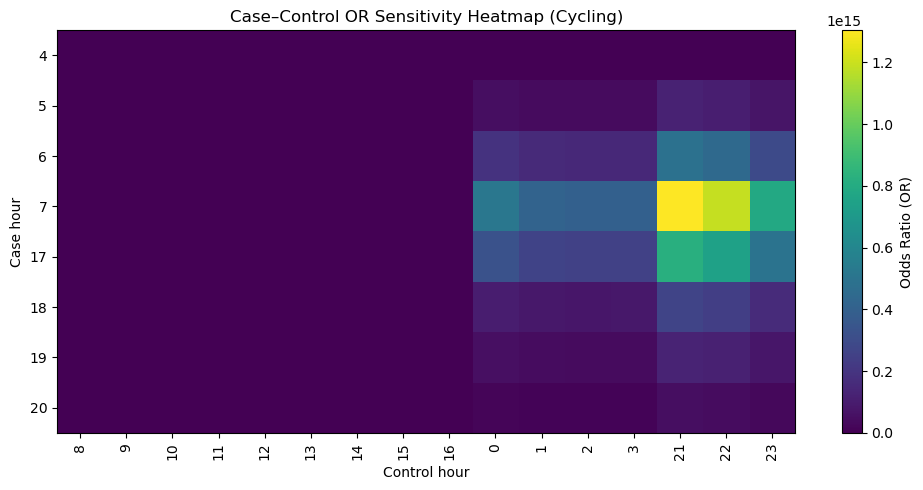


                            RESULTS: CASE–CONTROL OR (CYCLING)                            
Case hours: 8  |  Control hours: 16  |  OR estimates: 128
Median OR: 0.000
IQR OR: 0.000 to 79157798760612.750



In [6]:
or_cyc = build_or_matrix(lit, "cyc", case_hours, controls)

plt.figure(figsize=(10,5))
plt.imshow(or_cyc.values, aspect="auto")
plt.colorbar(label="Odds Ratio (OR)")
plt.xticks(range(len(or_cyc.columns)), or_cyc.columns, rotation=90)
plt.yticks(range(len(or_cyc.index)), or_cyc.index)
plt.xlabel("Control hour")
plt.ylabel("Case hour")
plt.title("Case–Control OR Sensitivity Heatmap (Cycling)")
plt.tight_layout()
plt.show()

vals = or_cyc.values.flatten()
vals = vals[np.isfinite(vals)]

print("\n" + "="*90)
print("RESULTS: CASE–CONTROL OR (CYCLING)".center(90))
print("="*90)
print(f"Case hours: {len(case_hours)}  |  Control hours: {len(controls)}  |  OR estimates: {len(vals)}")
print(f"Median OR: {np.median(vals):.3f}")
print(f"IQR OR: {np.percentile(vals,25):.3f} to {np.percentile(vals,75):.3f}")
print("="*90 + "\n")


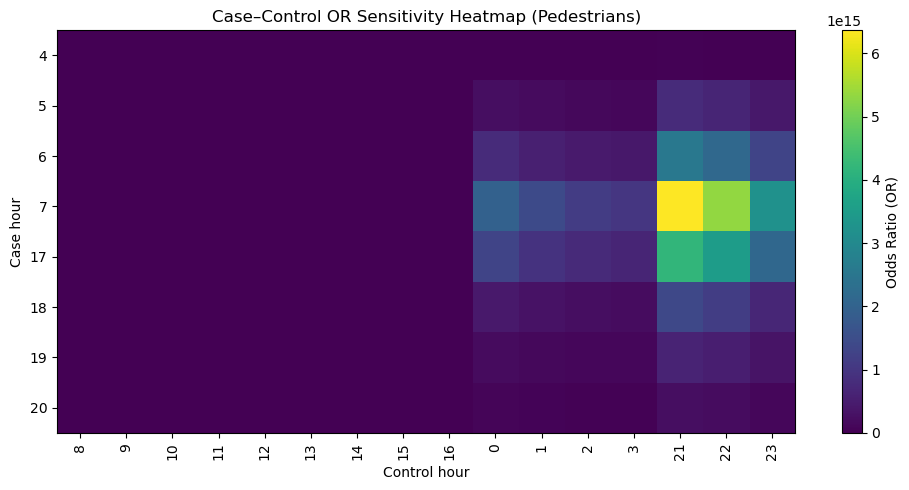


                          RESULTS: CASE–CONTROL OR (PEDESTRIANS)                          
Case hours: 8  |  Control hours: 16  |  OR estimates: 128
Median OR: 0.000
IQR OR: 0.000 to 260858944061193.250



In [7]:
or_ped = build_or_matrix(lit, "ped", case_hours, controls)

plt.figure(figsize=(10,5))
plt.imshow(or_ped.values, aspect="auto")
plt.colorbar(label="Odds Ratio (OR)")
plt.xticks(range(len(or_ped.columns)), or_ped.columns, rotation=90)
plt.yticks(range(len(or_ped.index)), or_ped.index)
plt.xlabel("Control hour")
plt.ylabel("Case hour")
plt.title("Case–Control OR Sensitivity Heatmap (Pedestrians)")
plt.tight_layout()
plt.show()

vals = or_ped.values.flatten()
vals = vals[np.isfinite(vals)]

print("\n" + "="*90)
print("RESULTS: CASE–CONTROL OR (PEDESTRIANS)".center(90))
print("="*90)
print(f"Case hours: {len(case_hours)}  |  Control hours: {len(controls)}  |  OR estimates: {len(vals)}")
print(f"Median OR: {np.median(vals):.3f}")
print(f"IQR OR: {np.percentile(vals,25):.3f} to {np.percentile(vals,75):.3f}")
print("="*90 + "\n")


<div style="font-size:20px; line-height:1.4">
<b>Results: Case–control OR sensitivity</b><br>
We computed odds ratios across many combinations of case and control hours. The resulting OR values vary with hour choice, demonstrating sensitivity to the definition of control hours, consistent with the key message of the reference paper. We report the distribution of OR values (median and IQR) and visualise sensitivity using heatmaps for both cycling and pedestrian counts.
</div>
